# • Quick Start

This notebook provides a quick start minimal example where we explore the main functionalities of the NeuralForecast library. The `core.NeuralForecast` class allows you to easily interact with `models.NeuralForecast` PyTorch models. In this example we visit the `NHITS/NBEATS`, you can check our PyTorch models [collection here](https://nixtla.github.io/neuralforecast/models.html).


You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/Getting_Started_with_NBEATS_and_NHITS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing NeuralForecast

In [ ]:
%%capture
!pip install neuralforecast

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS
from neuralforecast.utils import AirPassengersDF

## 2. Loading AirPassengers Data

The `core.NeuralForecast` class contains shared, `fit`, `predict` and other methods that take as inputs pandas DataFrames with columns `['unique_id', 'ds', 'y']` where `unique_id` identifies individual time series from the dataset, `ds` is the date, and `y` is the target variable. 

In this example dataset consists of a set of a single series, but you can easily fit your model to larger datasets in long format.

In [ ]:
Y_df = AirPassengersDF
Y_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


## 3. Model Training

### Split train/test sets

We split the dataset into train and test, keeping the last 12 months to evaluate the models.

In [ ]:
Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31']   # 12 test

### Fit the models

Using the `NeuralForecast.fit` method you can train a set of models to your dataset. You just have to define the `input_size` and `horizon` of your model. The `input_size` is the number of historic observations (lags) that the model will use to learn to predict `h` steps in the future. Also, you can modify the hyperparameters of the model to get a better accuracy.

In [ ]:
%%capture
horizon = len(Y_test_df)

# You can play with different initialization parameters
models = [NBEATS(input_size=2 * horizon, h=horizon, max_epochs=100,
                 stack_types=['trend', 'seasonality', 'identity']),
          NHITS(input_size=2 * horizon, h=horizon, max_epochs=100,
                n_freq_downsample=[2, 1, 1])]
fcst = NeuralForecast(models=models, freq='M')
fcst.fit(df=Y_train_df)

### Predict using the fitted models

Using the `NeuralForecast.predict` method you can obtain the predictions of the last observations, the length of the predictions are restricted to the horizon parameter `h`.

In [ ]:
Y_hat_df = fcst.predict().reset_index()
Y_hat_df.head()

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

,unique_id,ds,NBEATS,NHITS
0,1.0,1960-01-31,424.524475,418.684540
1,1.0,1960-02-29,400.308411,407.425659
2,1.0,1960-03-31,473.023132,468.379486
3,1.0,1960-04-30,463.574280,455.614441
4,1.0,1960-05-31,475.464722,469.580078


## 4. Evaluate Predictions

We are going to plot the models againts the real values of test. 

The default `NBEATS-i` interpretable model decomposes its predictions with projections into trend and seasonalities.

While `NHITS` model that builds upon the general fully connected version of `NBEATS` but uses interpolation in its multi-step predictons as regularizer.

Both methods exhibit very good performance when compared to classic AutoARIMA and Exponential Smoothing (ETS).

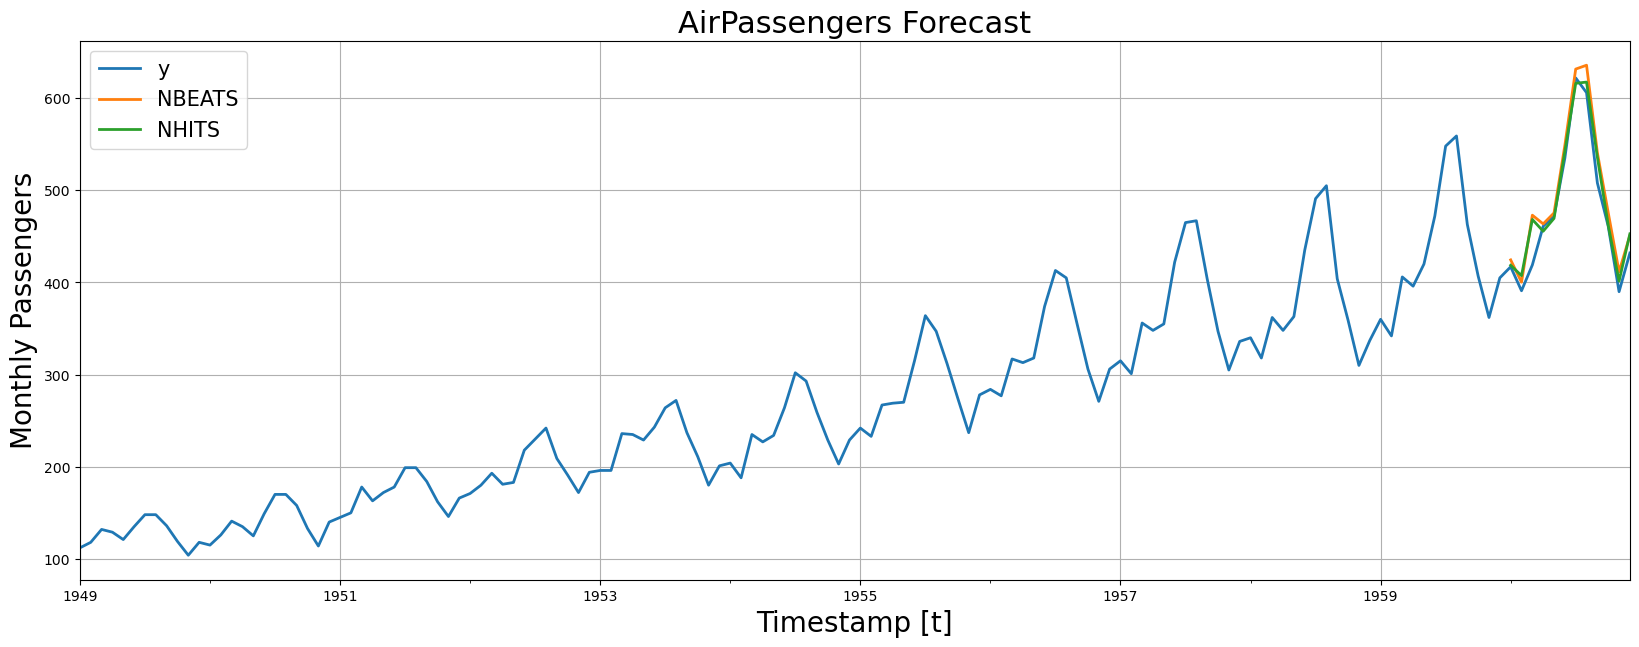

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y', 'NBEATS', 'NHITS']].plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

Finally, we evaluate the predictions accuracy using the Mean Absolute Error:

$$
\qquad MAE = \frac{1}{Horizon} \sum_{\tau} |y_{\tau} - \hat{y}_{\tau}|\qquad
$$

In [ ]:
def mae(y_hat, y_true):
    return np.mean(np.abs(y_hat-y_true))

y_true = Y_test_df['y'].values
nbeats_preds = Y_hat_df['NBEATS'].values
nhits_preds = Y_hat_df['NHITS'].values

print('NHITS     MAE: %0.3f' % mae(nhits_preds, y_true))
print('NBEATS    MAE: %0.3f' % mae(nbeats_preds, y_true))
print('ETS       MAE: 16.222')
print('AutoARIMA MAE: 18.551')

NHITS     MAE: 13.453
NBEATS    MAE: 18.206
ETS       MAE: 16.222
AutoARIMA MAE: 18.551


You can find [here](https://nixtla.github.io/statsforecast/examples/getting_started_with_auto_arima_and_ets.html) the reproduction of the ETS and AutoARIMA performances.

## References
- [Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio (2020). "N-BEATS: Neural basis expansion analysis for interpretable time series forecasting". International Conference on Learning Representations.](https://arxiv.org/abs/1905.10437)
- [Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2021). "N-HiTS: Neural Hierarchical Interpolation for Time Series Forecasting". Work in progress paper, submitted to AAAI.](https://arxiv.org/abs/2201.12886)
- [Rob J. Hyndman, Yeasmin Khandakar (2008). “Automatic Time Series Forecasting: The forecast package for R”](https://www.jstatsoft.org/article/view/v027i03)